In [14]:
!pip install efficientnet

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# DataGen

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [17]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [18]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


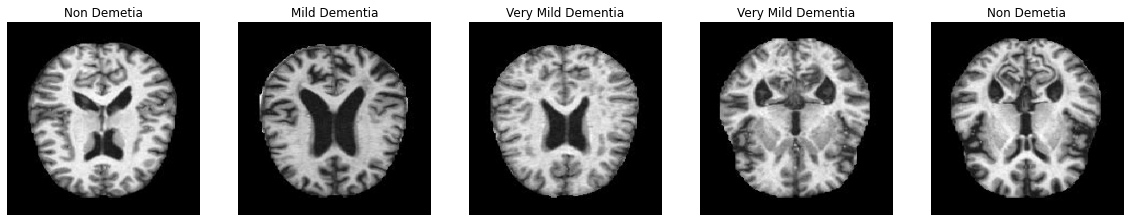

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [20]:
base_model = enet.EfficientNetB0(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

In [21]:
for layer in base_model.layers:
    layer.trainable=False

In [22]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 11520)             46080     
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [24]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.RMSprop(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [25]:
filepath = './model_tuning224_512_RMSprop1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [26]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.1129 - auc: 0.8108
Epoch 00001: val_auc improved from -inf to 0.66683, saving model to .\model_tuning224_512_RMSprop1e3.h5
65/65 [==============================] - 175s 3s/step - loss: 1.1129 - auc: 0.8108 - val_loss: 1.3790 - val_auc: 0.6668
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.8531 - auc: 0.8783
Epoch 00002: val_auc improved from 0.66683 to 0.70336, saving model to .\model_tuning224_512_RMSprop1e3.h5
65/65 [==============================] - 171s 3s/step - loss: 0.8531 - auc: 0.8783 - val_loss: 1.2394 - val_auc: 0.7034
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.7434 - auc: 0.9048
Epoch 00003: val_auc improved from 0.70336 to 0.72553, saving model to .\model_tuning224_512_RMSprop1e3.h5
65/65 [==============================] - 174s 3s/step - loss: 0.7434 - auc: 0.9048 - val_loss: 1.2078 - val_auc: 0.7255
Epoch 4/100
65/65 [==============================] -

Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.2426 - auc: 0.9876
Epoch 00030: val_auc did not improve from 0.93856
65/65 [==============================] - 173s 3s/step - loss: 0.2426 - auc: 0.9876 - val_loss: 0.6381 - val_auc: 0.9361
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.2099 - auc: 0.9910
Epoch 00031: val_auc did not improve from 0.93856
65/65 [==============================] - 171s 3s/step - loss: 0.2099 - auc: 0.9910 - val_loss: 0.6309 - val_auc: 0.9373
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.2173 - auc: 0.9900
Epoch 00032: val_auc improved from 0.93856 to 0.94615, saving model to .\model_tuning224_512_RMSprop1e3.h5
65/65 [==============================] - 174s 3s/step - loss: 0.2173 - auc: 0.9900 - val_loss: 0.5818 - val_auc: 0.9462
Epoch 33/100
65/65 [==============================] - ETA: 0s - loss: 0.1999 - auc: 0.9916
Epoch 00033: val_auc did not improve from 0.94615
65/65 [============

Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.1569 - auc: 0.9938
Epoch 00060: val_auc did not improve from 0.96351
65/65 [==============================] - 170s 3s/step - loss: 0.1569 - auc: 0.9938 - val_loss: 0.6095 - val_auc: 0.9471
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.1416 - auc: 0.9949
Epoch 00061: val_auc did not improve from 0.96351
65/65 [==============================] - 170s 3s/step - loss: 0.1416 - auc: 0.9949 - val_loss: 0.5699 - val_auc: 0.9539
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.1318 - auc: 0.9957
Epoch 00062: val_auc did not improve from 0.96351
65/65 [==============================] - 169s 3s/step - loss: 0.1318 - auc: 0.9957 - val_loss: 0.5295 - val_auc: 0.9578
Epoch 63/100
65/65 [==============================] - ETA: 0s - loss: 0.1353 - auc: 0.9957
Epoch 00063: val_auc did not improve from 0.96351
65/65 [==============================] - 169s 3s/step - loss: 0.1353 - auc: 

Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.1137 - auc: 0.9967
Epoch 00091: val_auc did not improve from 0.96776
65/65 [==============================] - 237s 4s/step - loss: 0.1137 - auc: 0.9967 - val_loss: 0.5049 - val_auc: 0.9628
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.1020 - auc: 0.9969
Epoch 00092: val_auc did not improve from 0.96776
65/65 [==============================] - 277s 4s/step - loss: 0.1020 - auc: 0.9969 - val_loss: 0.5289 - val_auc: 0.9604
Epoch 93/100
65/65 [==============================] - ETA: 0s - loss: 0.1060 - auc: 0.9965
Epoch 00093: val_auc did not improve from 0.96776
65/65 [==============================] - 280s 4s/step - loss: 0.1060 - auc: 0.9965 - val_loss: 0.5981 - val_auc: 0.9524
Epoch 94/100
65/65 [==============================] - ETA: 0s - loss: 0.1087 - auc: 0.9959
Epoch 00094: val_auc did not improve from 0.96776
65/65 [==============================] - 279s 4s/step - loss: 0.1087 - auc: 

In [27]:
  base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

block7a_bn (BatchNormalization) (None, 7, 7, 1152)   4608        block7a_dwconv[0][0]             
__________________________________________________________________________________________________
block7a_activation (Activation) (None, 7, 7, 1152)   0           block7a_bn[0][0]                 
__________________________________________________________________________________________________
block7a_se_squeeze (GlobalAvera (None, 1152)         0           block7a_activation[0][0]         
__________________________________________________________________________________________________
block7a_se_reshape (Reshape)    (None, 1, 1, 1152)   0           block7a_se_squeeze[0][0]         
__________________________________________________________________________________________________
block7a_se_reduce (Conv2D)      (None, 1, 1, 48)     55344       block7a_se_reshape[0][0]         
__________________________________________________________________________________________________
block7a_se

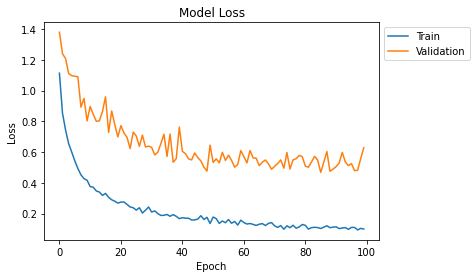

In [28]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

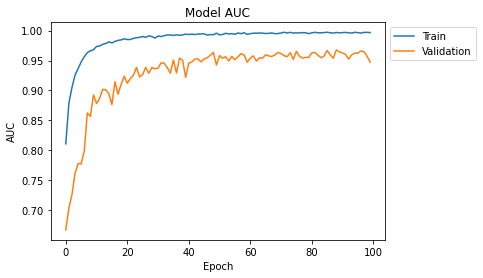

In [29]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

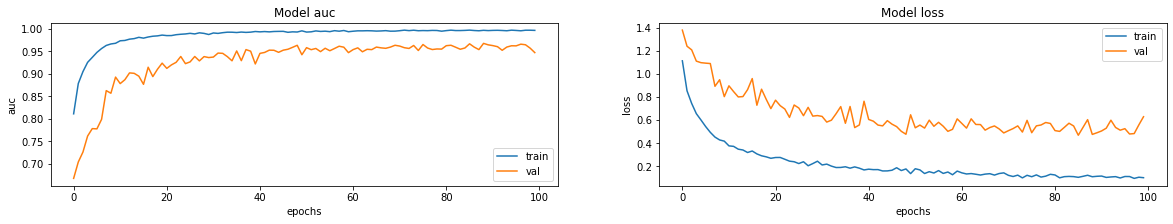

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [32]:
model.evaluate(test_dataset)

20/20 [==============================] - 67s 3s/step - loss: 0.8958 - auc: 0.9239


[0.8957822322845459, 0.9239280819892883]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
100.0 % chances are there that the image is NonDemented


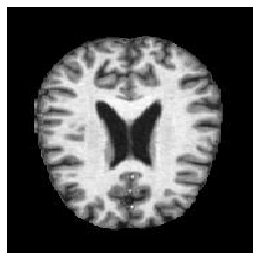

In [33]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

96.04 % chances are there that the image is MildDemented


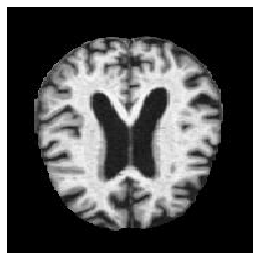

In [34]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is ModerateDemented


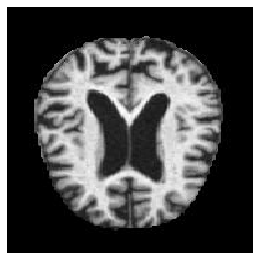

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is VeryMildDemented


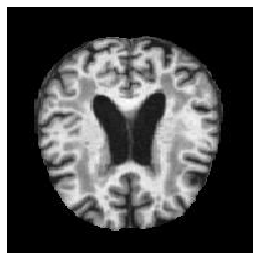

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [24]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

In [26]:
pred_ls = np.argmax(test_dataset, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

MemoryError: Unable to allocate 36.8 MiB for an array with shape (64, 224, 224, 3) and data type float32